In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [2]:
# Load the data from L1_8000rpm_data/ folder
X_train = pd.read_csv('8000rpm_data_z-score/train_sample_fft_scaled.csv').values
X_test = pd.read_csv('8000rpm_data_z-score/test_sample_fft_scaled.csv').values
y_train = pd.read_csv('8000rpm_data_z-score/train_label.csv').values
y_test = pd.read_csv('8000rpm_data_z-score/test_label.csv').values

# Convert data to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32).unsqueeze(1).to(device)
y_train = torch.tensor(y_train, dtype=torch.long).to(device)
y_test = torch.tensor(y_test, dtype=torch.long).to(device)

In [3]:
# Create DataLoader for batching
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [9]:
# Instantiate model, loss, and optimizer
from model import CNN
learning_rate = 0.000005
dropout_rate = 0.4
model = CNN(dropout_rate = dropout_rate, kernel_size = 3).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [10]:
# Train the model
num_epochs = 50
history = {'loss': [], 'accuracy': [], 'val_accuracy': []}
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels.argmax(dim=1))
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels.argmax(dim=1)).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_accuracy = correct / total
    history['loss'].append(epoch_loss)
    history['accuracy'].append(epoch_accuracy)
    
    model.eval()  # Set the model to evaluation mode
    val_correct = 0
    val_total = 0
    with torch.no_grad():  # No need to compute gradients for validation
        for inputs, labels in test_loader:  # Assuming you have a validation data loader
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == labels.argmax(dim=1)).sum().item()
            val_total += labels.size(0)

    val_accuracy = val_correct / val_total
    history['val_accuracy'].append(val_accuracy)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}, Validation Accuracy: {val_accuracy:.4f}")

Epoch 1/50, Loss: 2.0023, Accuracy: 0.2783, Validation Accuracy: 0.3867
Epoch 2/50, Loss: 1.6188, Accuracy: 0.3750, Validation Accuracy: 0.5844
Epoch 3/50, Loss: 1.4391, Accuracy: 0.4156, Validation Accuracy: 0.6289
Epoch 4/50, Loss: 1.3289, Accuracy: 0.4461, Validation Accuracy: 0.6711
Epoch 5/50, Loss: 1.2545, Accuracy: 0.5006, Validation Accuracy: 0.7600
Epoch 6/50, Loss: 1.1910, Accuracy: 0.5333, Validation Accuracy: 0.7844
Epoch 7/50, Loss: 1.1073, Accuracy: 0.5689, Validation Accuracy: 0.7578
Epoch 8/50, Loss: 1.0398, Accuracy: 0.5961, Validation Accuracy: 0.7933
Epoch 9/50, Loss: 0.9823, Accuracy: 0.6311, Validation Accuracy: 0.8133
Epoch 10/50, Loss: 0.9057, Accuracy: 0.6744, Validation Accuracy: 0.8267
Epoch 11/50, Loss: 0.8852, Accuracy: 0.6744, Validation Accuracy: 0.8289
Epoch 12/50, Loss: 0.8597, Accuracy: 0.6989, Validation Accuracy: 0.8311
Epoch 13/50, Loss: 0.8205, Accuracy: 0.7111, Validation Accuracy: 0.8489
Epoch 14/50, Loss: 0.7603, Accuracy: 0.7522, Validation Accu

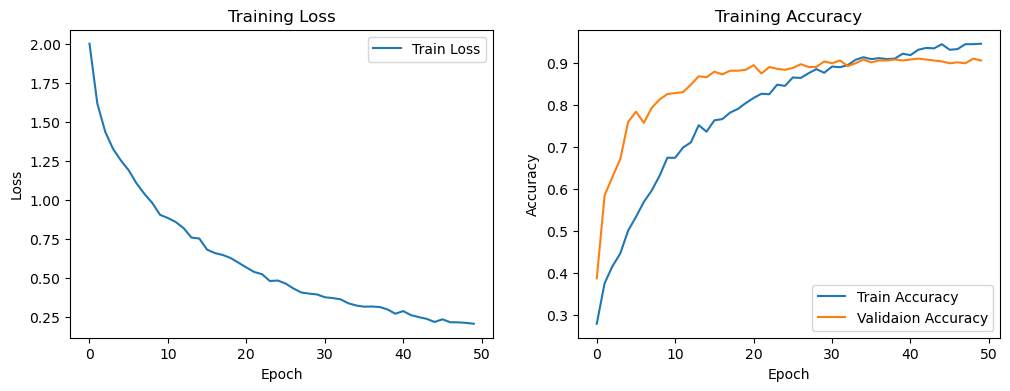

In [11]:
# Plot training loss and accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history['loss'], label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Loss')

plt.subplot(1, 2, 2)
plt.plot(history['accuracy'], label='Train Accuracy')
plt.plot(history['val_accuracy'], label='Validaion Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training Accuracy')

plt.savefig(f"./images/train_lr{learning_rate}_dr{dropout_rate}.png")
plt.show()

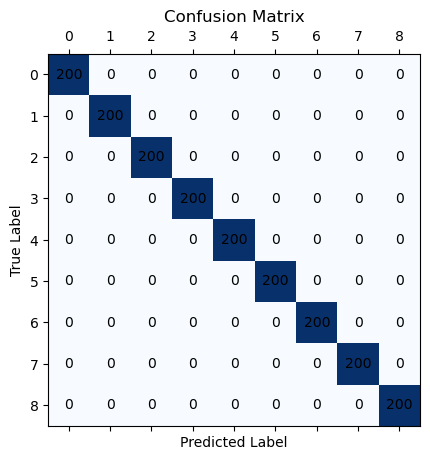

In [12]:
from sklearn.metrics import confusion_matrix

# 模型预测
y_pred_train = model(X_train)

y_pred_classes = np.argmax(y_pred_train.cpu().detach().numpy(), axis=1)
y_train_classes = np.argmax(y_train.cpu().detach().numpy(), axis=1)

# 计算混淆矩阵
conf_mat = confusion_matrix(y_train_classes, y_pred_classes)

# 绘制混淆矩阵
plt.matshow(conf_mat, cmap='Blues')
for i in range(conf_mat.shape[0]):
    for j in range(conf_mat.shape[1]):
        plt.text(x=j, y=i, s=conf_mat[i, j], va='center', ha='center')

plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

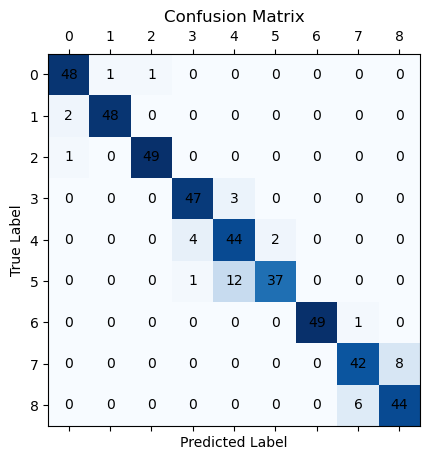

In [13]:
from sklearn.metrics import confusion_matrix

# 模型预测
y_pred = model(X_test)

y_pred_classes = np.argmax(y_pred.cpu().detach().numpy(), axis=1)
y_test_classes = np.argmax(y_test.cpu().detach().numpy(), axis=1)

# 计算混淆矩阵
conf_mat = confusion_matrix(y_test_classes, y_pred_classes)

# 绘制混淆矩阵
plt.matshow(conf_mat, cmap='Blues')
for i in range(conf_mat.shape[0]):
    for j in range(conf_mat.shape[1]):
        plt.text(x=j, y=i, s=conf_mat[i, j], va='center', ha='center')

plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [14]:
from sklearn.metrics import classification_report

# 评估
print("Classification Report:")
print(classification_report(y_pred=y_pred_classes, y_true=y_test_classes))

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.96      0.95        50
           1       0.98      0.96      0.97        50
           2       0.98      0.98      0.98        50
           3       0.90      0.94      0.92        50
           4       0.75      0.88      0.81        50
           5       0.95      0.74      0.83        50
           6       1.00      0.98      0.99        50
           7       0.86      0.84      0.85        50
           8       0.85      0.88      0.86        50

    accuracy                           0.91       450
   macro avg       0.91      0.91      0.91       450
weighted avg       0.91      0.91      0.91       450

